In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pyarrow import parquet as pq
import pyarrow as pa
import pandas as pd
from hostess.aws.s3 import Bucket
import os
import pdr
import numpy as np
from gPhoton.pipeline import execute_pipeline

import warnings
# Suppress all UserWarnings
warnings.filterwarnings('ignore', category=UserWarning)

from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from scipy.stats import gaussian_kde

from comparison_utils import *

In [14]:
eclipse = 23464
# for eclipse in np.arange(23456,23500):
datapath = f"/Users/cm/github/glcat/mcat_comparison/data"
mcat_path = get_mcat_file(eclipse,datapath)
mcat_cat_file = write_mcat_pos(eclipse,mcat_path,datapath)
   # for band in ['NUV','FUV']:
   #    run_pipeline_from_cat(eclipse,mcat_cat_file,datapath,band=band)#,compression='gzip')

In [4]:
phot = {'expt':
        pd.read_csv(f'{datapath}/e{str(eclipse).zfill(5)}/e{str(eclipse).zfill(5)}-nd-f0120-b00-movie-exptime.csv')}
aperture_sizes=[1.5, 2.3, 3.8, 6.0, 9.0, 12.8, 17.3]
for aper,aper_rad in enumerate(aperture_sizes):
    phot[f'APER_{int(aper+1)}'] = pd.read_csv(
        f'{datapath}/e{str(eclipse).zfill(5)}/e{str(eclipse).zfill(5)}-nd-f0120-b00-movie-photom-{str(aper_rad).replace(".","_")}-mon.csv'
    )

mcat_tbl = pdr.read(mcat_path)

In [9]:
aper = 5
catmags = mcat_tbl['GALEX_MERGED_SOURCE_LIST'][f'NUV_MAG_APER_{aper}'].values
ix = np.where((catmags>-50) & (catmags<50))# &
            #   (aper7['aperture_sum_mask']==0) &
            #   (aper7['aperture_sum_edge']==0))
cps = phot['APER_5']['aperture_sum'].values[ix]/phot['expt'].expt.sum()
bg_counts = (9**2)*(phot['APER_7']['aperture_sum'].values-phot['APER_6']['aperture_sum'].values)/(17.3**2-12.8**2)
gphot_mag_bgsub = counts2mag((phot['APER_5']['aperture_sum'].values-bg_counts)[ix]/phot['expt'].expt.sum(),'NUV')
mcat_skybg = np.pi*(9**2)*mcat_tbl['GALEX_MERGED_SOURCE_LIST']['nuv_skybg'].values*phot['expt'].expt.sum()
gphot_mag_mcatbgsub = counts2mag((phot['APER_5']['aperture_sum'].values-mcat_skybg)[ix]/phot['expt'].expt.sum(),'NUV')
mag = catmags[ix]+zpmag['NUV']
delta_mag = mag-gphot_mag_mcatbgsub
ix = np.where(np.isfinite(mag) & np.isfinite(delta_mag))
xy = np.vstack([mag[ix],delta_mag[ix]])
z = gaussian_kde(xy)(xy)

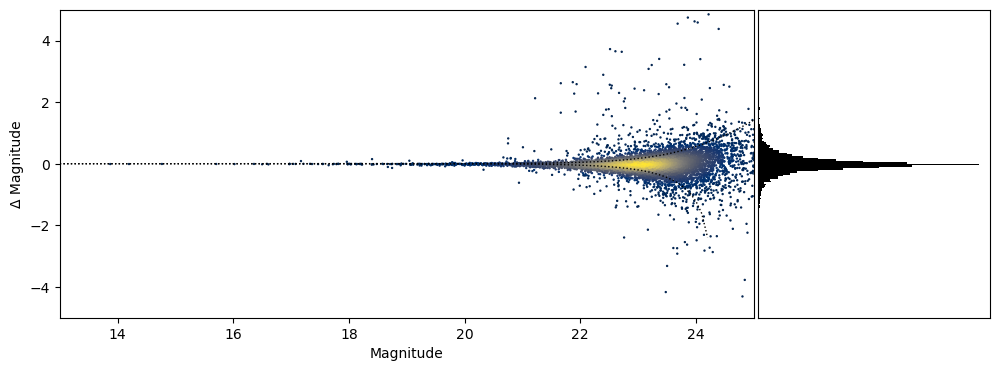

In [10]:
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 2, width_ratios=[3, 1], height_ratios=[1], wspace=0.01)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)

# Scatter plot
sc = ax1.scatter(mag[ix], delta_mag[ix], c=z, s=0.5, alpha=1, cmap="cividis")
ax1.set_xlim([13,25])
ax1.set_ylim([-5, 5])
ax1.set_xlabel('Magnitude')
ax1.set_ylabel('Δ Magnitude')

def dmag_errors(t, band, sigma=3., mode='mag', mags=np.arange(13, 30, 0.1)):
    cnts = mag2counts(mags, band)*t
    ymin = (cnts-sigma/np.sqrt(cnts))/t
    ymax = (cnts+sigma/np.sqrt(cnts))/t
    if mode == 'mag':
        ymin = mags-counts2mag(ymin, band)
        ymax = mags-counts2mag(ymax, band)
    return mags, ymin, ymax
dmag_err=dmag_errors(100.,'NUV',sigma=3)

ax1.plot(dmag_err[0], dmag_err[1], color='k', linestyle=':', lw=1, alpha=1,
         label='1.41{s}'.format(s=r'$\sigma$'))
ax1.plot(dmag_err[0],dmag_err[2],color='k',linestyle=':', lw=1, alpha=1)



# Histogram
ax2.hist(delta_mag[ix], bins=200, orientation='horizontal', color='black', alpha=1, range=[-5, 5])
ax2.set_xlim([0, ax2.get_xlim()[1]])

# Remove ticks from the right plot
ax2.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

plt.tight_layout()
plt.show()

